### Autoencoder Implementation for Dimensionality Reduction in Financial Time Series (8 ETFs)


- Autoencoders are neural networks designed for unsupervised learning of efficient data representations. They consist of:
    - Encoder: Compresses input into latent space representation
    - Decoder: Reconstructs input from latent space
    - Loss Function: Minimizes reconstruction error

Step 1: Data Preparation

In [16]:
pip 


Usage:   
  /opt/anaconda3/bin/python -m pip <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  inspect                     Inspect the python environment.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependencies.
  config                      Manage local and global configuration.
  search                      Search PyPI for packages.
  cache                       Inspect and manage pip's wheel cache.
  index                       Inspect information available from package indexes.
  wheel                       Build wheels from your requirements.
  hash                        Compute hashes of package archives.
  completion

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch

# Load your cleaned financial dataset
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = [  # my chosen feature list
    'returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
            'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits'
]
lookback = 20

# Prepare sequences: shape (samples, lookback, n_assets, n_features)
X_list = []
for i in range(lookback, len(data)):
    cur_date = data.iloc[i]['Date']
    day_slice = data[data['Date'] == cur_date]
    if set(assets) <= set(day_slice['Ticker']):
        sample = []
        valid = True
        for asset in assets:
            asset_slice = data[(data['Ticker'] == asset) & (data['Date'] <= cur_date)].tail(lookback)
            if len(asset_slice) == lookback:
                sample.append(asset_slice[features].values)  # (lookback, n_features)
            else:
                valid = False
                break
        if valid:
            X_list.append(np.stack(sample, axis=1))  # (lookback, n_assets, n_features)

X = np.array(X_list)  # (samples, lookback, n_assets, n_features)
print(f"Data shape before scaling: {X.shape}")


ModuleNotFoundError: No module named 'torch'

Step 2: Reshape and Standardize for Autoencoder Input:
- Autoencoders expect 2D input: samples × features. We flatten the temporal and asset dimensions:

In [4]:
samples, lb, n_assets, n_features = X.shape
X_flat = X.reshape(-1, n_features)  # (N, p)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


Step 3: the Autoencoder Neural Network

In [5]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=6):
        super().__init__()
        # Encoder: compress input to latent space
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder: reconstruct input from latent space
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

autoencoder = Autoencoder(input_dim=n_features, latent_dim=6)


Step 4: Train the Autoencoder

In [6]:
import torch.optim as optim

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train(model, data, epochs=100, batch_size=256):
    model.train()
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in loader:
            optimizer.zero_grad()
            recon, _ = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        losses.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
    return losses

loss_history = train(autoencoder, X_tensor, epochs=100)


Epoch 10/100, Loss: 0.016624
Epoch 20/100, Loss: 0.014937
Epoch 30/100, Loss: 0.014095
Epoch 40/100, Loss: 0.013570
Epoch 50/100, Loss: 0.013189
Epoch 60/100, Loss: 0.012927
Epoch 70/100, Loss: 0.012706
Epoch 80/100, Loss: 0.012555
Epoch 90/100, Loss: 0.012428
Epoch 100/100, Loss: 0.012290


Step 5: Visualizing Training Loss

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history, marker='o', color='blue')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Reconstruction Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


NameError: name 'loss_history' is not defined

<Figure size 1000x600 with 0 Axes>

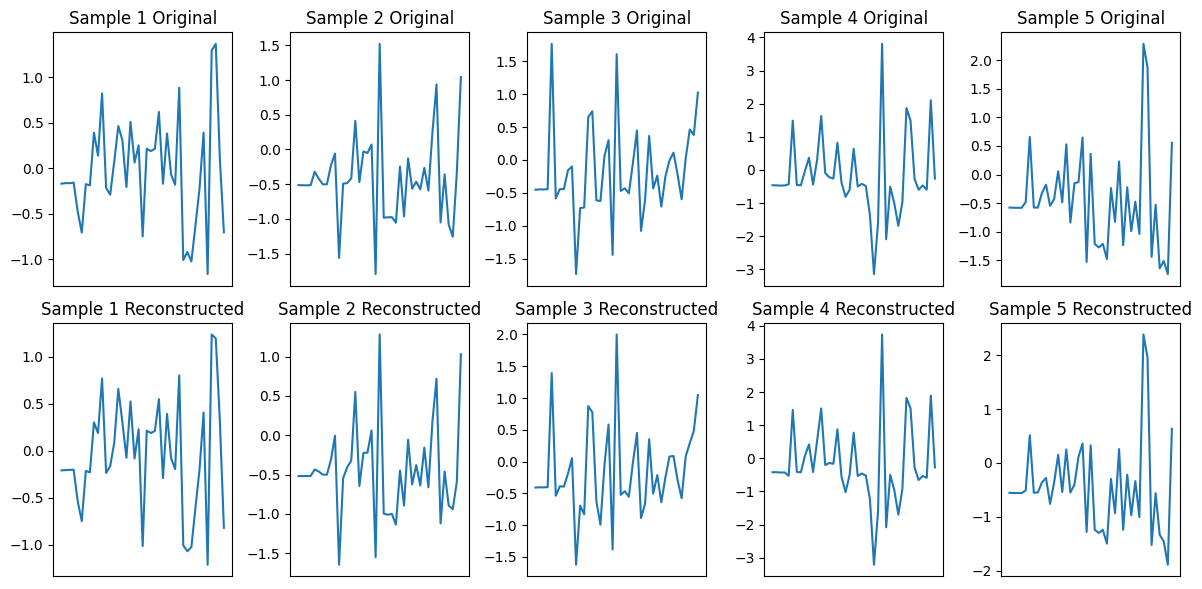

In [8]:
def plot_reconstructions(model, data, n_samples=5):
    model.eval()
    with torch.no_grad():
        indices = np.random.choice(len(data), n_samples)
        originals = data[indices]
        reconstructions, _ = model(originals)
        
        plt.figure(figsize=(12, 6))
        for i in range(n_samples):
            plt.subplot(2, n_samples, i + 1)
            plt.plot(originals[i].numpy(), label='Original')
            plt.title(f'Sample {i+1} Original')
            plt.xticks([])
            plt.subplot(2, n_samples, i + 1 + n_samples)
            plt.plot(reconstructions[i].numpy(), label='Reconstructed')
            plt.title(f'Sample {i+1} Reconstructed')
            plt.xticks([])
        plt.tight_layout()
        plt.show()

plot_reconstructions(autoencoder, X_tensor)



In [9]:
autoencoder.eval()
with torch.no_grad():
    _, latent = autoencoder(X_tensor)
latent_np = latent.numpy()

# Reshape latent vectors back to (samples, lookback, n_assets, latent_dim)
latent_reshaped = latent_np.reshape(samples, lb, n_assets, -1)
print(f"Latent space shape: {latent_reshaped.shape}")


Latent space shape: (18568, 20, 8, 6)


In [10]:
import pandas as pd

# Create column names
latent_dim = latent_np.shape[1]
latent_cols = [f'Latent_{i+1}' for i in range(latent_dim)]

# Create DataFrame and save
df_latent = pd.DataFrame(latent_np, columns=latent_cols)
df_latent.to_csv('autoencoder_latent.csv', index=False)
print("Saved latent representations to 'autoencoder_latent.csv'")


Saved latent representations to 'autoencoder_latent.csv'


/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_46345/3986597297.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_np[:, 0], latent_np[:, 1], alpha=0.5, cmap='viridis')


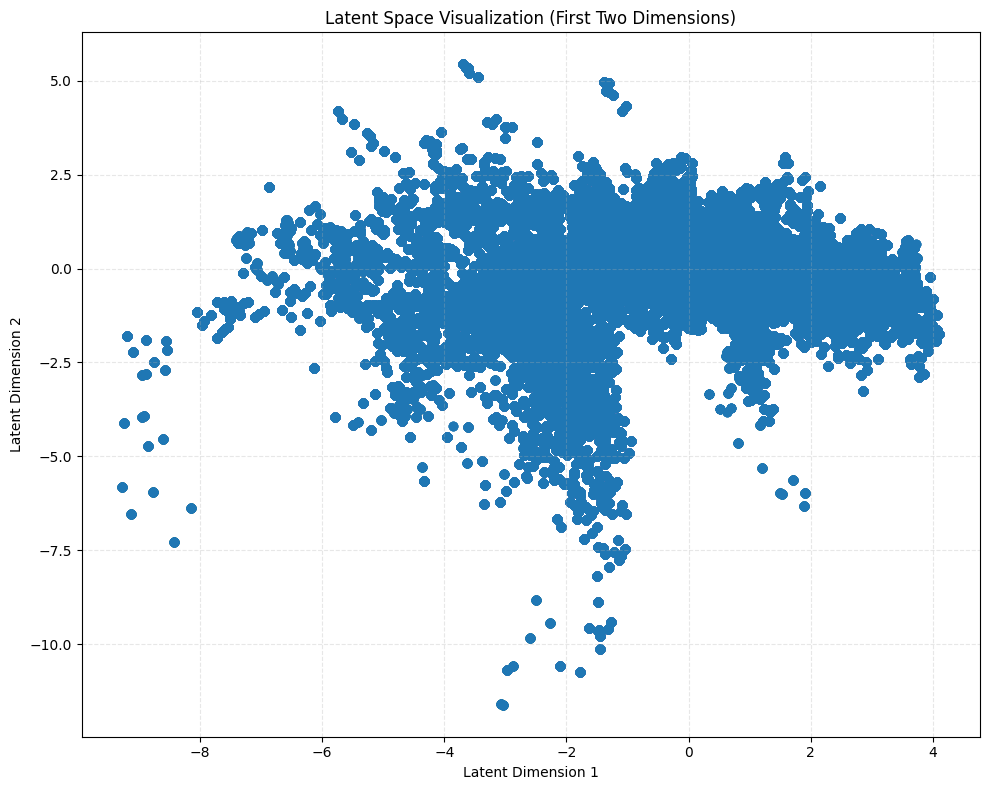

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(latent_np[:, 0], latent_np[:, 1], alpha=0.5, cmap='viridis')
plt.title('Latent Space Visualization (First Two Dimensions)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_46345/1387813953.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], alpha=0.5, cmap='viridis')


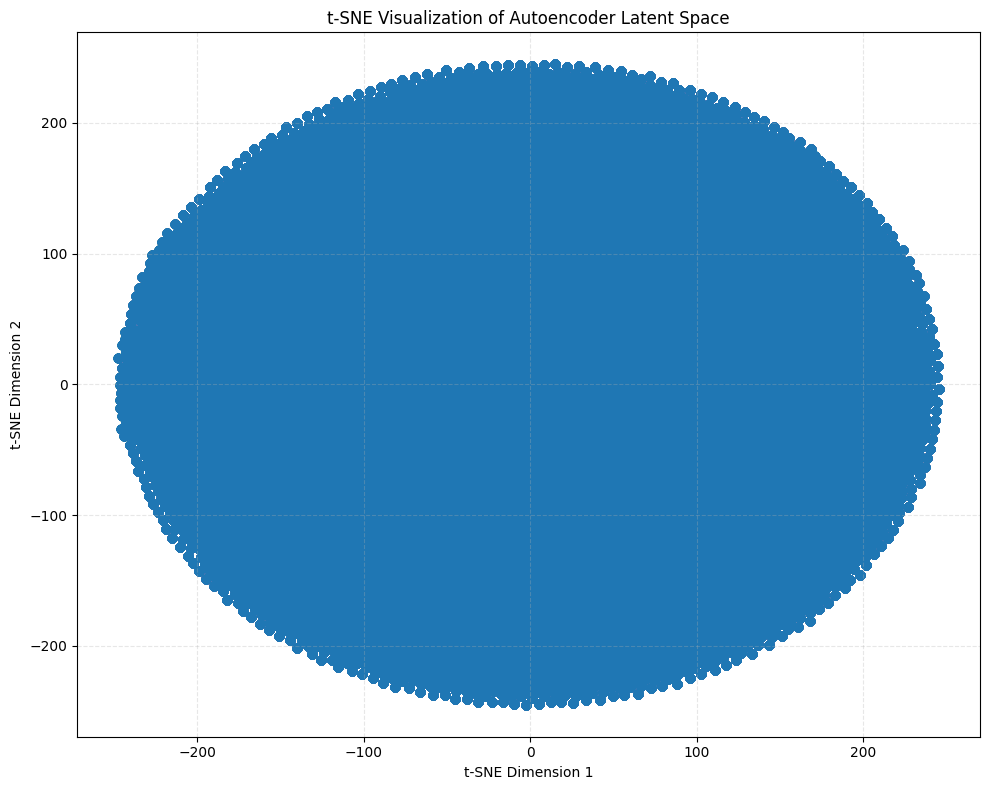

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_np)

plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], alpha=0.5, cmap='viridis')
plt.title('t-SNE Visualization of Autoencoder Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [1]:
import torch
from torchinfo import summary
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoded_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Example usage for layer summary:

input_dim = 19  
encoded_dim = 7

model_autoencoder = Autoencoder(input_dim=input_dim, encoded_dim=encoded_dim)

# Print model summary with batch size 32
summary(model_autoencoder, input_size=(32, input_dim))


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 7]                   --
├─Sequential: 1-1                        [32, 7]                   --
│    └─Linear: 2-1                       [32, 128]                 2,560
│    └─ReLU: 2-2                         [32, 128]                 --
│    └─Linear: 2-3                       [32, 7]                   903
├─Sequential: 1-2                        [32, 19]                  --
│    └─Linear: 2-4                       [32, 128]                 1,024
│    └─ReLU: 2-5                         [32, 128]                 --
│    └─Linear: 2-6                       [32, 19]                  2,451
Total params: 6,938
Trainable params: 6,938
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.03
Estimated Total Size (MB): 0.10

In [3]:
from graphviz import Digraph

g = Digraph('Autoencoder_Architecture_Large', format='png')
g.attr(bgcolor='#FFFFFF')
g.attr(rankdir='LR', splines='polyline', dpi='300', size='20,8')  # Large, high-res, landscape

# Input node: wide, 3D-style
g.node('input', 'Input Layer\n(batch, features)\n(e.g., 32, 19)', 
       shape='box3d', width='1.5', height='1.8',
       style='filled', fillcolor='#FFE066', fontname='Arial Black', fontsize='22')

# Encoder group as a cluster
with g.subgraph(name='cluster_encoder') as enc:
    enc.attr(style='dashed', color='#4890F0', label='Encoder', fontname='Arial Black', fontsize='20')
    enc.node('enc_linear1', 'Linear Layer\n19 → 128', 
             shape='box', style='filled', fillcolor='#F3B0C3', fontname='Arial Black', fontsize='20', width='1.3', height='1.1')
    enc.node('enc_relu1', 'ReLU', 
             shape='rect', style='rounded,filled', fillcolor='#A5E0FA', fontname='Arial Black', fontsize='20', width='1', height='0.8')
    enc.node('enc_linear2', 'Linear Layer\n128 → 64', 
             shape='box', style='filled', fillcolor='#F3B0C3', fontname='Arial Black', fontsize='20', width='1.3', height='1.1')
    enc.node('enc_relu2', 'ReLU', 
             shape='rect', style='rounded,filled', fillcolor='#A5E0FA', fontname='Arial Black', fontsize='20', width='1', height='0.8')
    enc.node('enc_linear3', 'Linear Layer\n64 → 7 (Latent)', 
             shape='box', style='filled', fillcolor='#F3B0C3', fontname='Arial Black', fontsize='20', width='1.3', height='1.1')
    enc.edge('enc_linear1', 'enc_relu1', color='#4890F0', penwidth='3')
    enc.edge('enc_relu1', 'enc_linear2', color='#4890F0', penwidth='3')
    enc.edge('enc_linear2', 'enc_relu2', color='#4890F0', penwidth='3')
    enc.edge('enc_relu2', 'enc_linear3', color='#4890F0', penwidth='3')

# Latent bottleneck: bold, oval
g.node('latent', 'Latent Space\n(batch, dim)\n(e.g., 32, 7)', 
       shape='ellipse', style='filled,bold', 
       fillcolor='#4CAF50', fontname='Arial Black', fontsize='24', fontcolor='white', width='1.7', height='1.4')

# Decoder group as a cluster
with g.subgraph(name='cluster_decoder') as dec:
    dec.attr(style='dashed', color='#45B39D', label='Decoder', fontname='Arial Black', fontsize='20')
    dec.node('dec_linear1', 'Linear Layer\n7 → 64', 
             shape='box', style='filled', fillcolor='#A5D6A7', fontname='Arial Black', fontsize='20', width='1.3', height='1.1')
    dec.node('dec_relu1', 'ReLU', 
             shape='rect', style='rounded,filled', fillcolor='#C8E6C9', fontname='Arial Black', fontsize='20', width='1', height='0.8')
    dec.node('dec_linear2', 'Linear Layer\n64 → 128', 
             shape='box', style='filled', fillcolor='#A5D6A7', fontname='Arial Black', fontsize='20', width='1.3', height='1.1')
    dec.node('dec_relu2', 'ReLU', 
             shape='rect', style='rounded,filled', fillcolor='#C8E6C9', fontname='Arial Black', fontsize='20', width='1', height='0.8')
    dec.node('dec_linear3', 'Linear Layer\n128 → 19\n(Reconstruction)', 
             shape='box', style='filled', fillcolor='#A5D6A7', fontname='Arial Black', fontsize='20', width='1.3', height='1.1')
    dec.edge('dec_linear1', 'dec_relu1', color='#45B39D', penwidth='3')
    dec.edge('dec_relu1', 'dec_linear2', color='#45B39D', penwidth='3')
    dec.edge('dec_linear2', 'dec_relu2', color='#45B39D', penwidth='3')
    dec.edge('dec_relu2', 'dec_linear3', color='#45B39D', penwidth='3')

# Output node: wide, 3D-style
g.node('output', 'Output Layer\n(batch, features)\n(e.g., 32, 19)', 
       shape='box3d', width='1.5', height='1.8',
       style='filled', fillcolor='#AFE1AF', fontname='Arial Black', fontsize='22')

# Main flow arrows — thick, black
g.edge('input', 'enc_linear1', color='black', arrowhead='normal', penwidth='4')
g.edge('enc_linear3', 'latent', color='#388E3C', arrowhead='normal', penwidth='4')
g.edge('latent', 'dec_linear1', color='#388E3C', arrowhead='normal', penwidth='4')
g.edge('dec_linear3', 'output', color='black', arrowhead='normal', penwidth='4')

# Title at bottom center
g.attr(label='Autoencoder Architecture for Dimensionality Reduction (Landscape, Large)', 
       labelloc='b', labeljust='c', fontsize='28')

# Segment annotation row, aligned below each pipeline step (increase size for readability)
annotations = ['Input', 'Encoder', 'Latent', 'Decoder', 'Output']
positions = ['0', '1', '2', '3', '4']
for i, label_text in enumerate(annotations):
    node_id = f'b{i+1}'
    g.node(node_id, label_text, shape='plaintext', pos=f'{i}, -1!', fontname='Arial Black', fontsize='18')
# Invisibly align annotation nodes
g.edge('input', 'b1', arrowhead='none', style='invis')
g.edge('enc_linear1', 'b2', arrowhead='none', style='invis')
g.edge('latent', 'b3', arrowhead='none', style='invis')
g.edge('dec_linear1', 'b4', arrowhead='none', style='invis')
g.edge('output', 'b5', arrowhead='none', style='invis')

g.render('autoencoder_architecture_large', view=True)


'autoencoder_architecture_large.png'